In [1]:
# System modules
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# User modules
from domain.base import DataRequest
import domain.fs_engine as netatmo
from domain.elevation_service import (
    ElevationServiceConnector
)

from helpers.utils import (
    get_station_coordinates,
    add_station_elevations
)
import helpers.knmi_obs_ingest as knmi


In [4]:
# Defining a request for the Netherlands
request = DataRequest()
start_dt = datetime(2016, 3, 25, 0, 0)
end_dt = datetime(2016, 4, 13, 15, 0)
request.start_datetime = start_dt
request.end_datetime = end_dt
request.time_resolution = 10
request.region = (53.680, 2.865, 50.740, 7.323)
print("Request defined from %s to %s" % (start_dt, end_dt))

Request defined from 2016-03-25 00:00:00 to 2016-04-13 15:00:00


In [5]:
print("Querying KNMI observation data..")
knmi_path = 'X:/netatmo/obs/'
knmi_fsengine = knmi.FileSystemEngine(knmi_path)
obs_data = knmi_fsengine.query(request)

Querying KNMI observation data..
Loading 2831 files in total.
File 1: o03242340.txt
File 2: o03242350.txt
File 3: o03250000.txt
File 4: o03250010.txt
File 5: o03250020.txt
File 6: o03250030.txt
File 7: o03250040.txt
File 8: o03250050.txt
File 9: o03250100.txt
File 10: o03250110.txt
File 11: o03250120.txt
File 12: o03250130.txt
File 13: o03250140.txt
File 14: o03250150.txt
File 15: o03250200.txt
File 16: o03250210.txt
File 17: o03250220.txt
File 18: o03250230.txt
File 19: o03250240.txt
File 20: o03250250.txt
File 21: o03250300.txt
File 22: o03250310.txt
File 23: o03250320.txt
File 24: o03250330.txt
File 25: o03250340.txt
File 26: o03250350.txt
File 27: o03250400.txt
File 28: o03250410.txt
File 29: o03250420.txt
File 30: o03250430.txt
File 31: o03250440.txt
File 32: o03250450.txt
File 33: o03250500.txt
File 34: o03250510.txt
File 35: o03250520.txt
File 36: o03250530.txt
File 37: o03250540.txt
File 38: o03250550.txt
File 39: o03250600.txt
File 40: o03250610.txt
File 41: o03250620.txt
File

In [3]:
# Query netatmo data
netatmo_path = 'X:/netatmo/data/'
print("Querying NetAtmo file system engine..")
netatmo_fsengine = netatmo.FileSystemEngine(netatmo_path)
response = netatmo_fsengine.query(request)
data_map = response.data_map
print("%d stations loaded." % len(data_map))

Querying NetAtmo file system engine..
Loading 3169 files in total.
File 1: netatmo_20160325_0000.json.gz
Total number of stations:           11631
Points in file:                     141777
Points out of region:               130146
Points ignored:                     358
New stations:                       11631
Points added to dataset:            11273

File 2: netatmo_20160325_0010.json.gz
Total number of stations:           11631
Points in file:                     141777
Points out of region:               130146
Points ignored:                     11631
New stations:                       0
Points added to dataset:            0

File 3: netatmo_20160325_0020.json.gz
Total number of stations:           11636
Points in file:                     141703
Points out of region:               130081
Points ignored:                     393
New stations:                       5
Points added to dataset:            11229

File 4: netatmo_20160325_0030.json.gz
Total number of stations:       

In [10]:
import pickle
with open("data/netherlands_3-25_4-15.pkl", "rb") as f:
    data_map = pickle.load(f)

In [11]:
# Select stations at or near De Bilt
debilt_map = {}
for station_id in data_map:
    station = data_map[station_id]
    if station.latitude < 52.12 and station.longitude > 5.16 and station.latitude > 52.089373 and station.longitude < 5.205046:
        debilt_map[station_id] = station
print("%d stations near De Bilt." % len(debilt_map))
netatmo.resample_and_interpolate(debilt_map, request.time_resolution)
print("Done.")

5 stations near De Bilt.
0 / 5 stations processed..
Done.


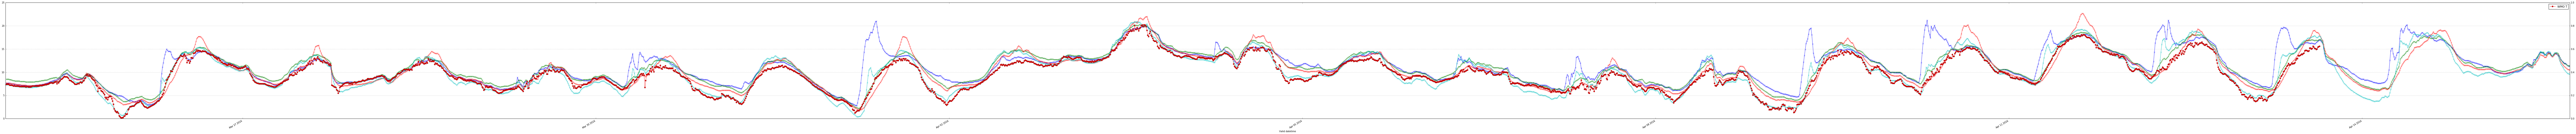

In [27]:
# %matplotlib inline
fig, ax = plt.subplots(1, figsize=(200, 10))
plt.xlabel("Valid datetime")

element = 'temperature'

gp = obs_data.groupby('station_id')
debilt_obs = gp.get_group(6260)
if element == 'pressure':
    knmi_name = 'p0'
elif element == 'temperature':
    knmi_name = 'ta'
elif element == 'humidity':
    knmi_name = 'rh'
debilt_obs_el = debilt_obs[debilt_obs.element_name==knmi_name]
debilt_obs_qg = debilt_obs[debilt_obs.element_name=='qg']


for station_id in debilt_map:
    station = debilt_map[station_id].thermo_module
    # Drop nan-columns
    station.dropna(axis=1, inplace=True)
#     print(station)
    if element in station:
        p = plt.plot(station.index.values, station[element].values, marker='x', label=None)
# Plot WMO
ax.plot(debilt_obs_el['valid_datetime'].values, debilt_obs_el['value'].values, color='red', marker='o', label='WMO T')
ax2 = ax.twinx()
# ax2.plot(debilt_obs_qg['valid_datetime'].values, debilt_obs_qg['value'].values, color='green', marker='o', label='WMO QG')
# ax2.set_ylabel("Incoming radiation")
plt.grid('on')

fig.autofmt_xdate()
ax.legend(numpoints=1)
plt.show()


In [5]:
import pickle
with open('data/netherlands_3-25_4-15.pkl', 'wb') as f:
    pickle.dump(data_map, f)

In [7]:
obs_data

,valid_datetime,station_id,element_name,value
0,2016-03-24 23:40:00,6210,D1H,NaN
1,2016-03-24 23:40:00,6210,Q1H,0.000000
2,2016-03-24 23:40:00,6210,R12H,0.467833
3,2016-03-24 23:40:00,6210,R1H,0.180833
4,2016-03-24 23:40:00,6210,R24H,0.550833
5,2016-03-24 23:40:00,6210,R6H,0.467834
6,2016-03-24 23:40:00,6210,Sav1H,8.972834
7,2016-03-24 23:40:00,6210,Sax1H,9.460000
8,2016-03-24 23:40:00,6210,Sax3H,9.460000
9,2016-03-24 23:40:00,6210,Sax6H,9.460000
